# Cost Curve Creator

This notebook enables fitting curves to ORBIT cost models, visualizing them,
and exporting to the NRWAL format. Functions are included for a variety of curve
shapes and more can be added as needed.

In [1]:
%matplotlib widget

from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats, optimize, linalg

from ORBIT import (
    ParametricManager,
    load_config,
)

# NOTE: must install:
# ipympl    # enables interactive matplotlib elements in jupyter notebooks via the `%matplotlib widget` magic command above

## Instructions

This notebook is used to generate cost curves for NRWAL based on the ORBIT model.
Follow the steps below to configure and run the notebook.

1. Create a basic ORBIT configuration file including at least the following sections:
- site
- turbine
- plant

2. Configure the notebook by setting the following variables:
- `base_config_path`: the path to the ORBIT configuration file
- `DEPTHS`: the list of dea bed depths to use for the cost curves
- Add any additional global parameter ranges

3. Run the notebook to establish a basic fit for the ORBIT data. This will also plot the ORBIT
data and curves.

4. Refine the curve fits by swapping the curve-fit function from the options available in
the "Curve Fit Library" section



TODO:
- Provide a template for a 1-dimensional and 2-dimensional cost function
- Compare the different mpl APIs for 2d vs 3d plots

## Global Variables

Replace any of these throughout the notebook to customize a curve fit or plot.

In [2]:
base_config_path = "nrwal.yaml"
base_config = load_config(base_config_path)

DEPTHS = [i for i in range(5, 60, 5)]           # Ocean depth in meters
MEAN_WIND_SPEED = [i for i in range(2, 20, 2)]  # Mean wind speed in m/s

## Curve Fit Library

These functions enable fitting a curve to a set of points based on a variety of curve shapes.
They should always be generic, so the global variables should not be used here.

In [3]:
def line_eval(slope, intercept, data_points):
    return np.array([slope * i + intercept for i in data_points])

def linear_1d(x, y, fit_check=False):
    """
    Fits a line to a set of 2D data points with the SciPy stats library.
    """
    slope, intercept, rvalue, pvalue, stderr = stats.linregress(x, y)

    if fit_check:
        print(f"Slope: {slope:.6f}")
        print(f"Intercept: {intercept:.6f}")
        print(f"R-squared: {rvalue**2:.6f}")

    curve = line_eval(slope, intercept, x)
    return curve

def linear_poly(x, y, fit_check=False):

    def f(x, a, b):
        return a * x + b

    popt, pcov = optimize.curve_fit(f, x, y)
    slope, intercept = popt[0], popt[1]

    if fit_check:
        print(f"Slope: {slope:.6f}")
        print(f"Intercept: {intercept:.6f}")
        # print(f"R-squared: {rvalue**2:.6f}")

    curve = line_eval(slope, intercept, x)
    return curve

In [4]:
def quadratic():
    pass

In [5]:
def logarithmic():
    pass

In [6]:
def exponential():
    pass

In [7]:
def linear_2d(x, y, z, fit_check=False):

    data_to_fit = np.array(list(zip(x, y, z)))

    # Best-fit linear plane
    A = np.c_[data_to_fit[:,0], data_to_fit[:,1], np.ones(data_to_fit.shape[0])]
    C,_,_,_ = linalg.lstsq(A, data_to_fit[:,2])    # coefficients

    # Evaluate it on the same points as the input data
    Z = C[0]*x + C[1]*y + C[2]

    return Z

def quadratic_2d(x, y, z, fit_check=False):
    """
    Fits a quadratic surface to the data points.
    x and y are the independent variables, and data is the dependent variable.
    Each of the arguments should be given directly from ORBIT and they are transformed
    here into the required form for use with the curve fitting library.
    """

    data_to_fit = np.array(list(zip(x, y, z)))

    # best-fit quadratic curve
    A = np.c_[
        np.ones(data_to_fit.shape[0]),
        data_to_fit[:,:2],
        np.prod(data_to_fit[:,:2], axis=1),
        data_to_fit[:,:2]**2
    ]
    C,_,_,_ = linalg.lstsq(A, data_to_fit[:,2])

    # Evaluate it on the same points as the input data
    Z = np.dot(np.c_[np.ones(x.shape), x, y, x*y, x**2, y**2], C).reshape(x.shape)

    return Z

# ORBIT Design Phase Cost Curves

## Monopile Substructure

Dependent variables:
- Water depth: impacts the mass of the monopile since it is fixed to the ocean floor
- Mean wind speed: impact the mass of the monopile by the load transferred from the turbine

ORBIT library intialized at '/Users/rmudafor/Development/orbit/library'


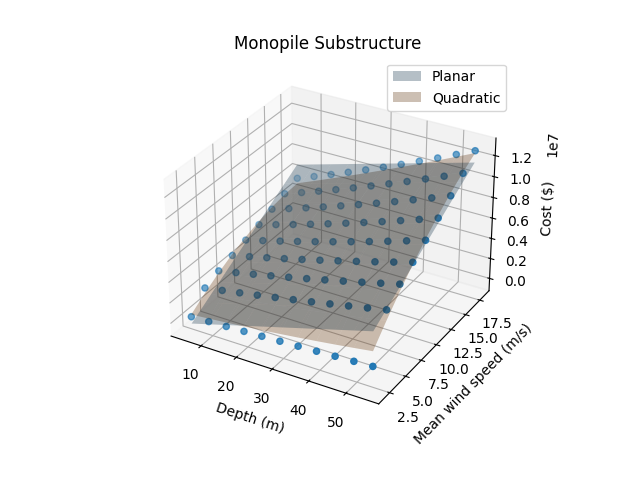

In [8]:
config = deepcopy(base_config)
config["design_phases"] = ["MonopileDesign"]
parameters = {
    "site.depth": DEPTHS,
    "site.mean_windspeed": MEAN_WIND_SPEED,
}
results = {
    "monopile_unit_cost": lambda run: run.design_results["monopile"]["unit_cost"],
    "transition_piece_unit_cost": lambda run: run.design_results["transition_piece"]["unit_cost"],
}
parametric = ParametricManager(config, parameters, results, product=True)
parametric.run()

x = parametric.results["site.depth"]
y = parametric.results["site.mean_windspeed"]
z = parametric.results["monopile_unit_cost"]

surface_linear = linear_2d(x, y, z)
surface_quadratic = quadratic_2d(x, y, z)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_title("Monopile Substructure")

# Plot the ORBIT data
ax.scatter(x, y, zs=z, zdir='z')

# Plot the surface
ax.plot_surface(
    np.reshape(x, (len(DEPTHS), -1)),
    np.reshape(y, (len(DEPTHS), -1)),
    np.reshape(surface_linear, (len(DEPTHS), -1)),
    alpha=0.3,
    label="Planar"
)
ax.plot_surface(
    np.reshape(x, (len(DEPTHS), -1)),
    np.reshape(y, (len(DEPTHS), -1)),
    np.reshape(surface_quadratic, (len(DEPTHS), -1)),
    alpha=0.3,
    label="Quadratic"
)

ax.set_xlabel("Depth (m)")
ax.set_ylabel("Mean wind speed (m/s)")
ax.set_zlabel("Cost ($)")
ax.legend()
plt.show()

## Mooring System

For all types, the line length is a function of water depth.

For TLP systems, line length is the difference between the water depth and the draft.

For SemiTaut systems, line length is the sum of rope length and chain length.
Rope length is defined from a fixed relationship for depth and rope lengths.
Chain length is also defined from a fixed relationship for depth and chain diameter.
While the semi-taut system line length is dependent on rope length and chain length, the parameters
are fixed and depend on water depth so they are not included in this parameterization.

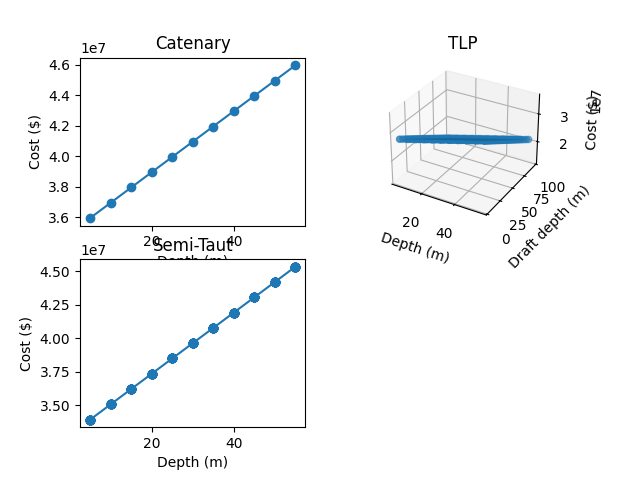

In [9]:
config = deepcopy(base_config)
config["design_phases"] = ["MooringSystemDesign"]
parameters = {
    "site.depth": DEPTHS,
}
results = {
    "mooring_system_system_cost": lambda run: run.design_results["mooring_system"]["system_cost"],
}

## Run ORBIT for each mooring system type

# Catenary mooring system
parameters["mooring_system_design.mooring_type"] = ["Catenary"]
parametric_catenary = ParametricManager(config, parameters, results, product=True)
parametric_catenary.run()

# Tension Leg Platform (TLP) mooring system
parameters["mooring_system_design.mooring_type"] = ["TLP"]
parameters["mooring_system_design.draft_depth"] = [i for i in range(5, 100, 5)] # Draft depth 5-100 meters
parametric_tlp = ParametricManager(config, parameters, results, product=True)
parametric_tlp.run()

# Semi-taut mooring system
parameters["mooring_system_design.mooring_type"] = ["SemiTaut"]
parametric_semitaut = ParametricManager(config, parameters, results, product=True)
parametric_semitaut.run()

## Fit the data to a curve

x_catenary = parametric_catenary.results["site.depth"]
z_catenary = parametric_catenary.results["mooring_system_system_cost"]
curve_catenary = linear_1d(x_catenary, z_catenary)

x_tlp = parametric_tlp.results["site.depth"]
y_tlp = parametric_tlp.results["mooring_system_design.draft_depth"]
z_tlp = parametric_tlp.results["mooring_system_system_cost"]
curve_tlp = linear_2d(x_tlp, y_tlp, z_tlp)

x_semitaut = parametric_semitaut.results["site.depth"]
z_semitaut = parametric_semitaut.results["mooring_system_system_cost"]
curve_semitaut = linear_1d(x_semitaut, z_semitaut)

## Plot the ORBIT data and curve fits

fig = plt.figure()

ax = fig.add_subplot(2, 2, 1)
ax.set_title("Catenary")
ax.set_xlabel("Depth (m)")
ax.set_ylabel("Cost ($)")
ax.scatter(x_catenary, z_catenary)
ax.plot(x_catenary, curve_catenary)

ax = fig.add_subplot(2, 2, 2, projection='3d')
ax.set_title("TLP")
ax.set_xlabel("Depth (m)")
ax.set_ylabel("Draft depth (m)")
ax.set_zlabel("Cost ($)")
ax.scatter(x_tlp, y_tlp, zs=z_tlp, zdir='z')
ax.plot_surface(
    np.reshape(x_tlp, (len(DEPTHS), -1)),
    np.reshape(y_tlp, (len(DEPTHS), -1)),
    np.reshape(curve_tlp, (len(DEPTHS), -1)),
    alpha=0.3,
    label="Quadratic"
)

ax = fig.add_subplot(2, 2, 3)
ax.set_title("Semi-Taut")
ax.set_xlabel("Depth (m)")
ax.set_ylabel("Cost ($)")
ax.scatter(x_semitaut, z_semitaut)
ax.plot(x_semitaut, curve_semitaut)

## Array System

The array system cost is entirely dependent on the cable length.
The cable length is a function of some fixed plant parameters and the following spatially
dependent parameters:
- water depth
- touchdown distance
- floating cable depth

The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.RuntimeWarning: /Users/rmudafor/Development/orbit/ORBIT/phases/design/_cables.py:386
The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.RuntimeWarning: /Users/rmudafor/Development/orbit/ORBIT/phases/design/_cables.py:386
The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.RuntimeWarning: /Users/rmudafor/Development/orbit/ORBIT/phases/design/_cables.py:386
The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.

The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.RuntimeWarning: /Users/rmudafor/Development/orbit/ORBIT/phases/design/_cables.py:386
The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.RuntimeWarning: /Users/rmudafor/Development/orbit/ORBIT/phases/design/_cables.py:386
The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.RuntimeWarning: /Users/rmudafor/Development/orbit/ORBIT/phases/design/_cables.py:386
The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.

The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.RuntimeWarning: /Users/rmudafor/Development/orbit/ORBIT/phases/design/_cables.py:386
The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.RuntimeWarning: /Users/rmudafor/Development/orbit/ORBIT/phases/design/_cables.py:372
overflow encountered in coshRuntimeWarning: /Users/rmudafor/Development/orbit/ORBIT/phases/design/_cables.py:372
overflow encountered in cosh

The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.RuntimeWarning: /Users/rmudafor/Development/orbit/ORBIT/phases/design/_cables.py:386
The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.RuntimeWarning: /Users/rmudafor/Development/orbit/ORBIT/phases/design/_cables.py:372
overflow encountered in cosh

Text(0.5, 0, 'Cost ($)')

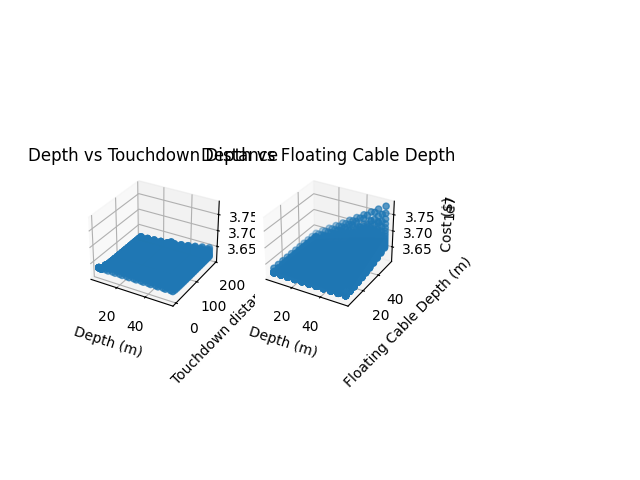

In [14]:
config = deepcopy(base_config)
config["design_phases"] = ["ArraySystemDesign"]
parameters = {
    "site.depth": DEPTHS,
    "array_system_design.touchdown_distance": [i for i in range(0, 200, 10)],
    "array_system_design.floating_cable_depth": DEPTHS,
}
results = {
    "array_system_system_cost": lambda run: run.design_results["array_system"]["system_cost"],
}
parametric = ParametricManager(config, parameters, results, product=True)
parametric.run()

x = parametric.results["site.depth"]
y_touchdown = parametric.results["array_system_design.touchdown_distance"]
y_floating_depth = parametric.results["array_system_design.floating_cable_depth"]
z = parametric.results["array_system_system_cost"]

curve_depth_touchdown = quadratic_2d(x, y_touchdown, z)
curve_depth_floatingdepth = quadratic_2d(x, y_floating_depth, z)
curve_floatingdepth_touchdown = quadratic_2d(y_touchdown, y_floating_depth, z)

fig = plt.figure()

ax = fig.add_subplot(1, 3, 1, projection='3d')
ax.set_title("Depth vs Touchdown Distance")
ax.scatter(x, y_touchdown, zs=z, zdir='z')
ax.plot_surface(
    np.reshape(x, (len(DEPTHS), -1)),
    np.reshape(y_touchdown, (len(DEPTHS), -1)),
    np.reshape(curve_depth_touchdown, (len(DEPTHS), -1)),
    alpha=0.3,
)
ax.set_xlabel("Depth (m)")
ax.set_ylabel("Touchdown distance (m)")
ax.set_zlabel("Cost ($)")

ax = fig.add_subplot(1, 3, 2, projection='3d')
ax.set_title("Depth vs Floating Cable Depth")
ax.scatter(x, y_floating_depth, zs=z, zdir='z')
ax.plot_surface(
    np.reshape(x, (len(DEPTHS), -1)),
    np.reshape(y_floating_depth, (len(DEPTHS), -1)),
    np.reshape(curve_depth_floatingdepth, (len(DEPTHS), -1)),
    alpha=0.3,
)
ax.set_xlabel("Depth (m)")
ax.set_ylabel("Floating Cable Depth (m)")
ax.set_zlabel("Cost ($)")

# TODO: This runs the three parameters as a product. To plot, reduce the data to 2 parameters.

## Export System
- site.distance_to_landfall
- Here, we must use parametric.results["site.depth"] instead of the global DEPTHS because the
- local depth list is broadcast to 2D for the product of the two lists.
- Plot curves for HVAC and HVDC cable types

AttributeError: PathCollection.set() got an unexpected keyword argument 'zs'

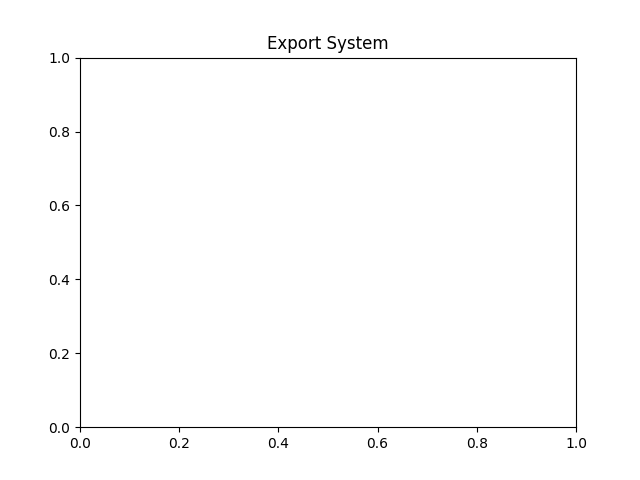

In [11]:
fig, ax = plt.subplots()
ax.set_title("Export System")

config = deepcopy(base_config)
config["design_phases"] = ["ExportSystemDesign"]
distance_to_landfall = [i for i in range(0, 400, 10)]
parameters = {
    "site.depth": DEPTHS,
    "site.distance_to_landfall": distance_to_landfall,
}
results = {
    "export_system_system_cost": lambda run: run.design_results["export_system"]["system_cost"],
}


## HVAC
config["export_system_design"]["cables"] = "XLPE_1000mm_220kV"
parametric = ParametricManager(config, parameters, results, product=True)
parametric.run()

curve_cost_depth = linear_1d(
    parametric.results["site.depth"],
    parametric.results["export_system_system_cost"]
)
curve_distance_to_landfall = linear_1d(
    parametric.results["site.distance_to_landfall"],
    parametric.results["export_system_system_cost"]
)

ax.scatter(
    parametric.results["site.depth"],
    parametric.results["site.distance_to_landfall"],
    zs=parametric.results["export_system_system_cost"],
    zdir='z',
    label="HVAC"
)
ax.plot(
    xs=parametric.results["site.depth"],
    ys=curve_cost_depth,
    zs=0,
    zdir="y",
    label='HVAC cost(depth)'
)
ax.plot(
    xs=parametric.results["site.distance_to_landfall"],
    ys=curve_distance_to_landfall,
    zs=0,
    zdir="x",
    label='HVAC cost(distance_to_landfall)'
)

## HVDC
config["export_system_design"]["cables"] = "XLPE_1000mm_220kV"
parametric = ParametricManager(config, parameters, results, product=True)
parametric.run()

curve_cost_depth = linear_1d(
    parametric.results["site.depth"],
    parametric.results["export_system_system_cost"]
)
curve_distance_to_landfall = linear_1d(
    parametric.results["site.distance_to_landfall"],
    parametric.results["export_system_system_cost"]
)

ax.scatter(
    parametric.results["site.depth"],
    parametric.results["site.distance_to_landfall"],
    zs=parametric.results["export_system_system_cost"],
    zdir='z',
    label="HVDC"
)
ax.plot(
    xs=parametric.results["site.depth"],
    ys=curve_cost_depth,
    zs=0,
    zdir="y",
    label='HVDC cost(depth)'
)
ax.plot(
    xs=parametric.results["site.distance_to_landfall"],
    ys=curve_distance_to_landfall,
    zs=0,
    zdir="x",
    label='HVDC cost(distance_to_landfall)'
)

ax.set_xlabel("Depth (m)")
ax.set_ylabel("Distance to landfall (km)")
ax.set_zlabel("Cost ($)")
ax.legend()







config = deepcopy(base_config)
config["design_phases"] = ["ArraySystemDesign"]
parameters = {
    "site.depth": DEPTHS,
}
results = {
    "array_system_system_cost": lambda run: run.design_results["array_system"]["system_cost"],
}
parametric = ParametricManager(config, parameters, results, product=True)
parametric.run()

curve = linear_1d(DEPTHS, parametric.results["array_system_system_cost"])

ax.scatter(DEPTHS, parametric.results["array_system_system_cost"], marker="+")
ax.plot(DEPTHS, curve)

ax.set_xlabel("Depth (m)")
ax.set_ylabel("Cost ($)")
# ax.legend()